In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
from matplotlib.dates import num2date,date2num

import xarray as xr
import pandas as pd
import os

from stompy import utils
from stompy.grid import unstructured_grid, multi_ugrid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

In [2]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.

# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


year  month  day  hour  minute  second  temp degC  \
time                                                                     
2016-04-06 23:24:00  2016      4    6    23      24       0     13.846   
2016-04-06 23:27:00  2016      4    6    23      27       0     13.269   
2016-04-06 23:30:00  2016      4    6    23      30       0     12.980   
2016-04-06 23:33:00  2016      4    6    23      33       0     12.883   
2016-04-06 23:36:00  2016      4    6    23      36       0     12.787   

                      depth m    NAVD88  
time                                     
2016-04-06 23:24:00  1.258192  1.258192  
2016-04-06 23:27:00  1.257183  1.257183  
2016-04-06 23:30:00  1.255166  1.255166  
2016-04-06 23:33:00  1.253148  1.253148  
2016-04-06 23:36:00  1.249114  1.249114

In [3]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017],sort=False)                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time'))                

In [4]:
# Updated test, using BML data
observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')

In [5]:
models=[ 
    pesca_base.PescaButano.load('data_salt_filling-v04_existing_impaired'),
    pesca_base.PescaButano.load('data_salt_filling-v04_existing_unimpaired'),
    pesca_base.PescaButano.load('data_salt_filling-v04_asbuilt_impaired'), #
    pesca_base.PescaButano.load('data_salt_filling-v04_asbuilt_unimpaired')   
       ]
model0=models[0]

<IPython.core.display.Javascript object>


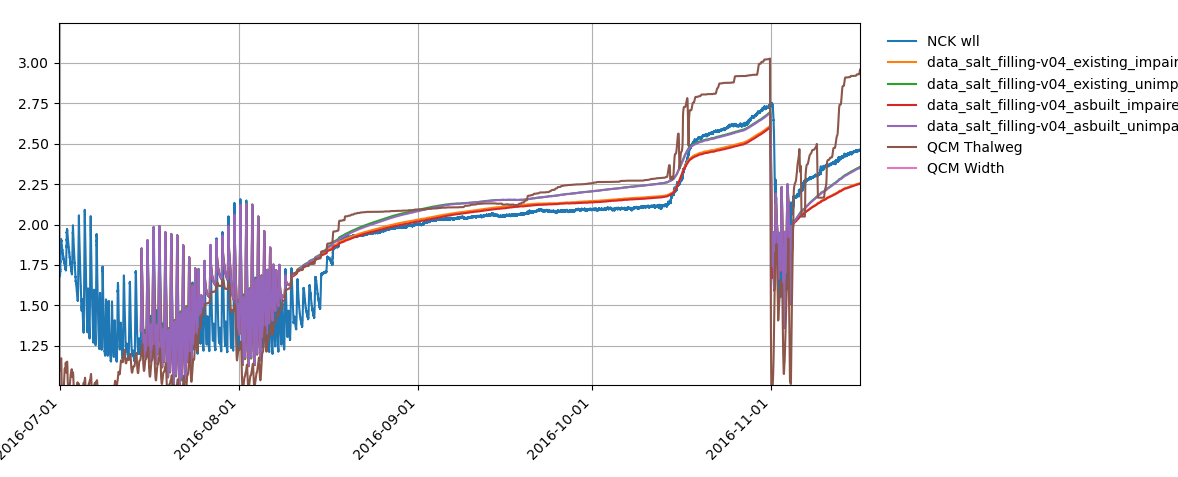

(16996.958333333332, 17151.041666666668, 0.0, 2.0)

In [12]:
sources=[observed]

for model in models: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207,0,2])

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

if 1: # Add in QCM time series
    ax.plot(qcm.time,qcm['z_thalweg'],label='QCM Thalweg')
    ax.plot(qcm.time,qcm['w_inlet'],label='QCM Width')    

fig.set_size_inches([9,4],forward=True)
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1], frameon=0)
ax.set_position([0.05,0.19,0.68,0.76])

ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))

Salinity Comparisons
--

In [6]:
# def load_bml(fname):
#     df=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/"+fname)
#     # UTC
#     df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
#     # some stations have some bad, -99 values
#     df.loc[df.salinity<0,'salinity']=np.nan
#     missing=df.time.isnull()
#     df=df[~missing]
#     df.set_index('time',inplace=True)
#     return df

# bml_nck_sfc_mcat=load_bml("NCK_sfc_mcat_concatenated.csv")
# bml_nck_btm_mcat=load_bml("NCK_btm_mcat_concatenated.csv")
# bml_pc3_sfc_sond=load_bml("PC3_sfc_sonde_concatenated.csv")
# bml_pc3_btm_sond=load_bml("PC3_btm_sonde_concatenated.csv")

# bml_bc1_btm_sond=load_bml("BC1_btm_sonde_concatenated.csv")
# bml_bc1_sfc_sond=load_bml("BC1_sfc_sonde_concatenated.csv")

# bml_bc3_btm_mcat=load_bml("BC3_btm_mcat_concatenated.csv")
# bml_bc3_sfc_mcat=load_bml("BC3_sfc_mcat_concatenated.csv")

# bml_ch2_btm_mcat=load_bml("CH2_btm_mcat_concatenated.csv")
# bml_ch2_sfc_mcat=load_bml("CH2_sfc_mcat_concatenated.csv")

    

In [7]:
def surface(da):
    # assume data array is {cell or time},layer
    scal=da.values
    valid=np.isfinite(scal)
    # This gets the index of the *last* True in each column
    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.take_along_axis(scal,surf_idxs[:,None],axis=1)[:,0]

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    # index of the *first* True in each column
    bed_idxs=np.argmax(valid,axis=1)
    return np.take_along_axis(scal,bed_idxs[:,None],axis=1)[:,0] 
    
def z_from_surface(da,dz):
    # assume layer is the second of 2 dimensions
    # recover freesurface and bed.
    # Slow. Maybe from xarray wrapping?
    eta=surface(da.z_upper)
    bed=bottom(da.zcoordinate_c) 
    z_target=np.maximum(eta-dz,bed) 
    
    # Same logic as grabbing the surface cell, but instead of 
    # testing for isfinite(scal), compare z_lower<z_target
    valid=da.z_lower.values<z_target[:,None]
    tgt_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    scal=da.values
    tgt=np.take_along_axis(scal,tgt_idxs[:,None],axis=1)[:,0]
    return tgt


def z_from_bottom(da,dz):
    # assume layer is the second of 2 dimensions
    # recover freesurface and bed.
    eta=surface(da.z_upper)
    bed=bottom(da.zcoordinate_c) 
    z_target=np.minimum(bed+dz,eta)
    valid=da.z_upper.values>=z_target[:,None]
    tgt_idxs=np.argmax(valid,axis=1)
    scal=da.values
    tgt=np.take_along_axis(scal,tgt_idxs[:,None],axis=1)[:,0]
    return tgt
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    layer_styles=[dict(lw=0.5,ls='-'),
                  dict(lw=0.5,ls='--')]
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:brown','tab:purple']
    model_dz=0.25 # pull data over a range of vertical levels if > 0
    model_label=None # defaults to run directory 
    fig_name="salt-timeseries-{name}-{t_start}-{t_stop}.png"
    show_observed=True
    
    @classmethod
    def load(cls,run_dirs,station_name,layer_geometry=False):
        """
        For each run_dir, load salinity history for the named station.
        Returns a list of DataArray.
        station_name: may need to be binary.
        layer_geometry: include layer geometry to later pull intermediate levels. 
        """
        das=[]
        for run_dir in run_dirs:
            his_fn=os.path.join(run_dir,'DFM_OUTPUT_flowfm','flowfm_0000_his.nc')
            ds=xr.open_dataset(his_fn)
            stn=np.nonzero( ds.station_name.values==station_name )[0][0]
            da=ds['salinity'].isel(stations=stn)
            da.attrs['label']=run_dir
            
            if layer_geometry:
                # Need extra information to properly handle vertical range
                zcoord_w=ds['zcoordinate_w'].isel(stations=stn)
                 
                # Appears that zcoordinate_w starts with a bed elevation,
                # ends with the surface
                # Important to rename coordinates, otherwise xarray tries to match
                # them up.
                layer_bottom=zcoord_w.isel(laydimw=slice(None,-1)).rename(laydimw='laydim',
                                                                          zcoordinate_w='z_lower')
                layer_top   =zcoord_w.isel(laydimw=slice(1,None)).rename(laydimw='laydim',
                                                                         zcoordinate_w='z_upper')
                del layer_bottom['zcoordinate_wu']
                del layer_top['zcoordinate_wu']

                da=da.assign_coords(z_lower=layer_bottom,
                                    z_upper=layer_top)

            das.append(da)                                
        return das
    
    def data_label(self,da):
        if self.model_label is None:
            return da.attrs['label']
        else:
            return self.model_label
        
    def __init__(self,run_dirs,his_name,bml_sfc,bml_btm,**kws):
        self.fig_dir='fig-unimpaired'
        utils.set_keywords(self,kws)
    
        self.das=self.load(run_dirs,his_name,layer_geometry=self.model_dz>0.0)
        self.his_name=his_name
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        self.fig=fig
        self.ax=ax

        labels=utils.distinct_substrings([self.data_label(stn_da) for stn_da in self.das])
        
        for color,stn_da in zip(self.colors[1:],self.das):
            # Pick out top/bottom finite values.
            scal=stn_da.values
            #da_label=self.data_label(stn_da)
            da_label=labels.pop(0)
            
            valid=np.isfinite(scal) # time,layer

            for ls,lay in zip(self.layer_styles,self.layers):
                lay_dz=None
                if lay=='surface':
                    lay_scal=surface(stn_da)
                    z_label="Surface"
                    if self.model_dz>0.0:
                        lay_dz=z_from_surface(stn_da,self.model_dz)
                elif lay=='bottom':
                    lay_scal=bottom(stn_da)
                    z_label="Bottom"
                    if self.model_dz>0.0:
                        lay_dz=z_from_bottom(stn_da,self.model_dz)
                elif isinstance(lay,(int,np.integer)):
                    # Pull a specifical layer:
                    lay_scal=scal[:,lay]
                    z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                    z_label=f"z={z:.2f} m"
                elif isinstance(lay,(float,np.float64)):
                    # Pull an elevation relative to the surface:
                    lay_scal=scal[:,lay]
                    lay_scal=z_from_surface(stn_da,lay)
                    z_label=f"z={lay:.2f} m below surface"
                ax.plot(stn_da.time, lay_scal,
                        label=f"{da_label} {z_label}", color=color, **ls)
                if lay_dz is not None:
                    ax.fill_between(stn_da.time.values, 
                                    lay_scal,lay_dz,label='__nolabel__',color=color,
                                    alpha=0.25)
            # Nan transitions:
            bad_salt=np.nonzero(np.diff(np.isnan(lay_scal))>0)[0]
            ax.plot(stn_da.time.values[1:][bad_salt],
                    0*bad_salt,'kx')
                        
        # BML Data
        if self.show_observed:
            for ls,lay in zip(self.layer_styles,self.layers):
                if lay=='surface':
                    ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                            color=self.colors[0],label="BML surface",**ls)
                elif lay=='bottom':
                    ax.plot(bml_btm.index.values, bml_btm.salinity, 
                            color=self.colors[0],label="BML bottom",**ls)
                else:
                    print(f"No bml data for layer={lay}")

        if 1: # legend across top
            ncol=len(self.das)
            if self.show_observed:
                ncol+=1
            fig.subplots_adjust(top=0.85)
            ax.legend(loc='lower center',bbox_to_anchor=[0.5,1.0],
                      frameon=False,ncol=ncol)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name.decode()
        ax.text(0.03,0.98,name.upper(),transform=ax.transAxes,va='top')
        ax.set_ylabel('Salinity (ppt)')
        self.save()
    def save(self):
        if (self.fig_dir is not None) and (not os.path.exists(self.fig_dir)):
            os.makedirs(self.fig_dir)
        name=self.his_name
        if not isinstance(name,str):
            name=name.decode()
        zoom=self.ax.axis()
        t_start=num2date(zoom[0]).strftime("%m%d")
        t_stop =num2date(zoom[1]).strftime("%m%d")
        
        fig_name=self.fig_name.format(name=name,t_start=t_start,t_stop=t_stop)
            
        self.fig.savefig(os.path.join(self.fig_dir,fig_name),
                         dpi=150)

<IPython.core.display.Javascript object>


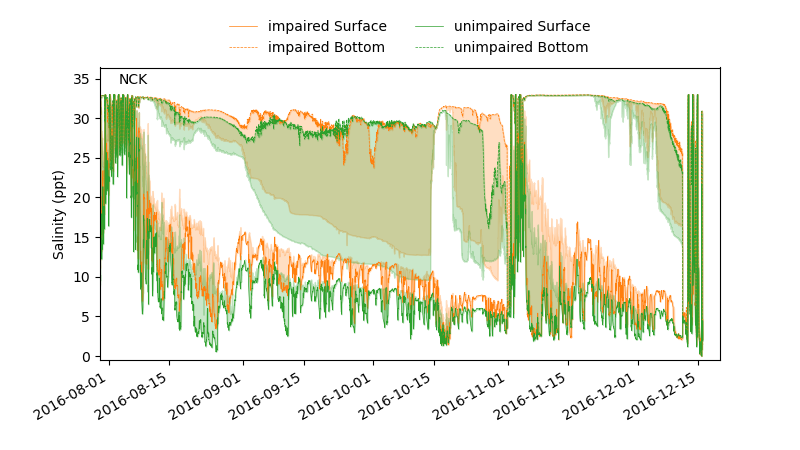

31 8


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


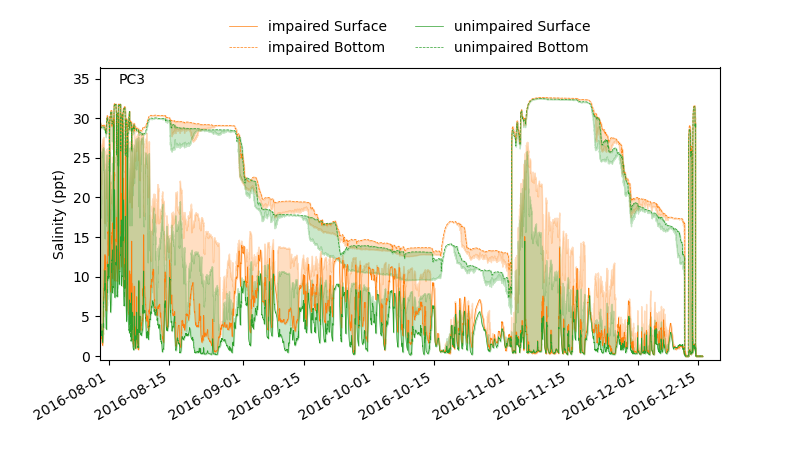

31 8


<IPython.core.display.Javascript object>


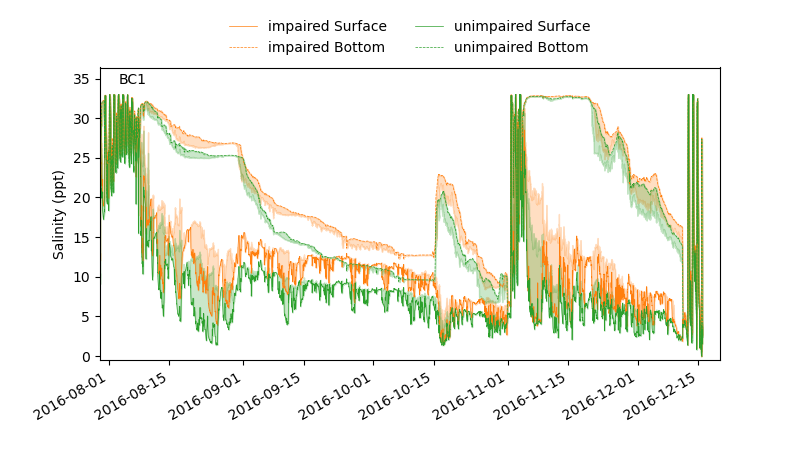

31 8


<IPython.core.display.Javascript object>


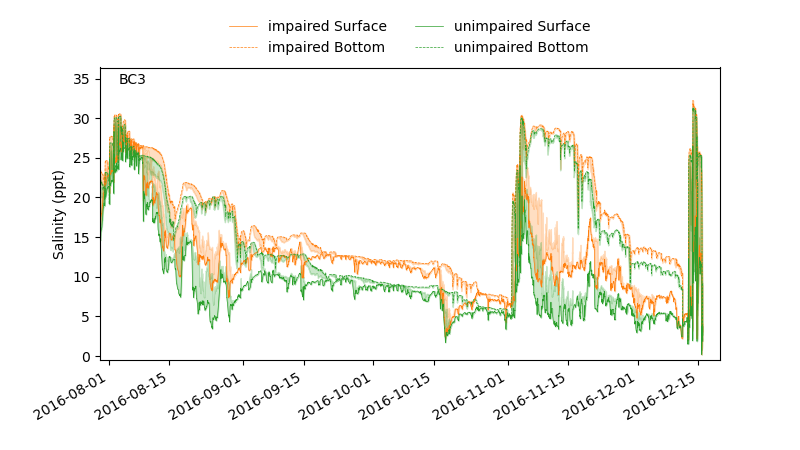

31 8


<IPython.core.display.Javascript object>


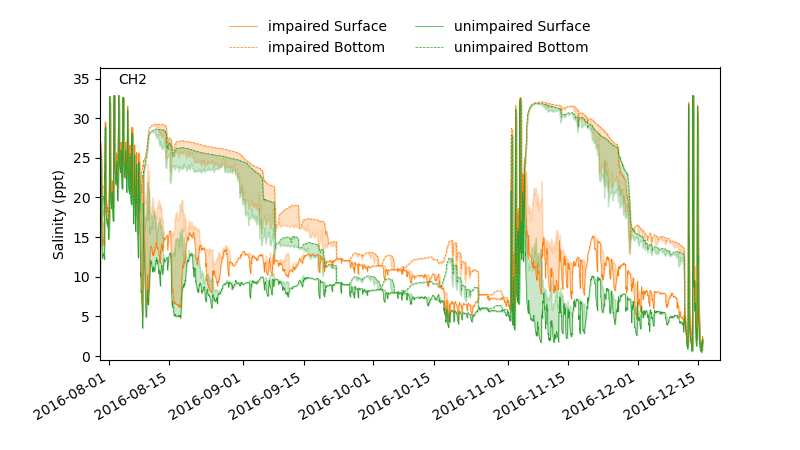

31 8


In [67]:
run_dirs=[m.run_dir for m in models[:2]]
kws=dict(zoom=(17012.0, 17155, -0.5, 36.4),show_observed=False,
         fig_name='salt_ts_existing_{name}.png')
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)

<IPython.core.display.Javascript object>


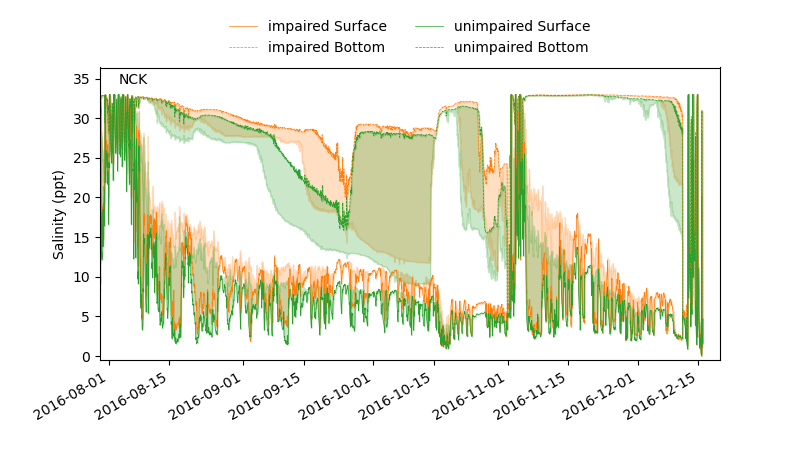

30 8


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


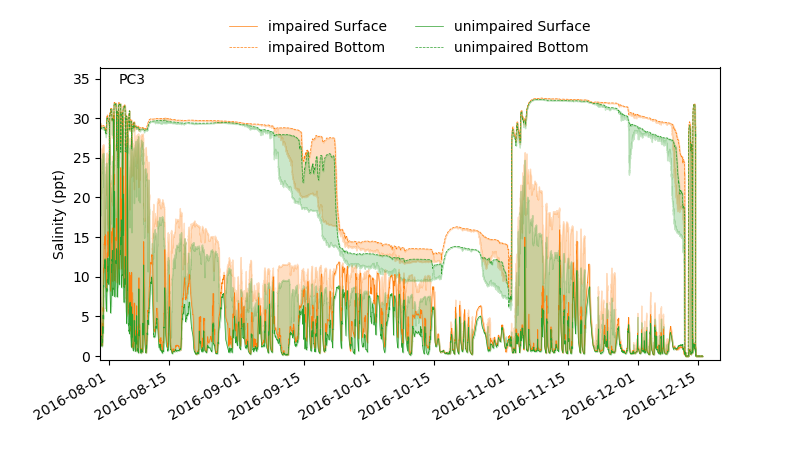

30 8


<IPython.core.display.Javascript object>


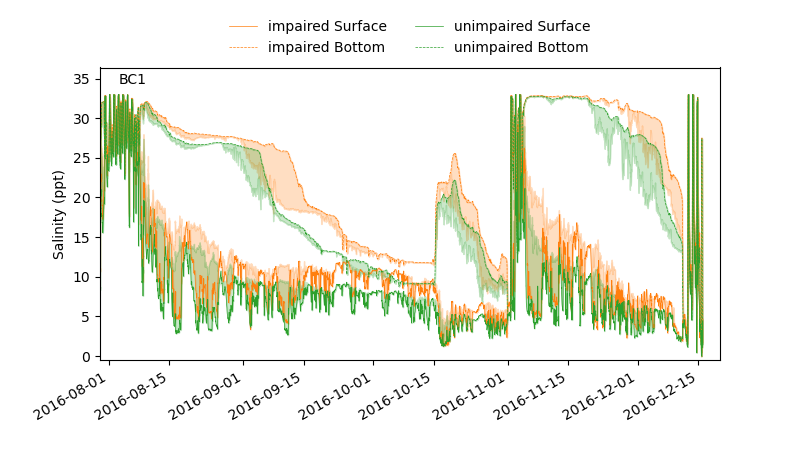

30 8


<IPython.core.display.Javascript object>


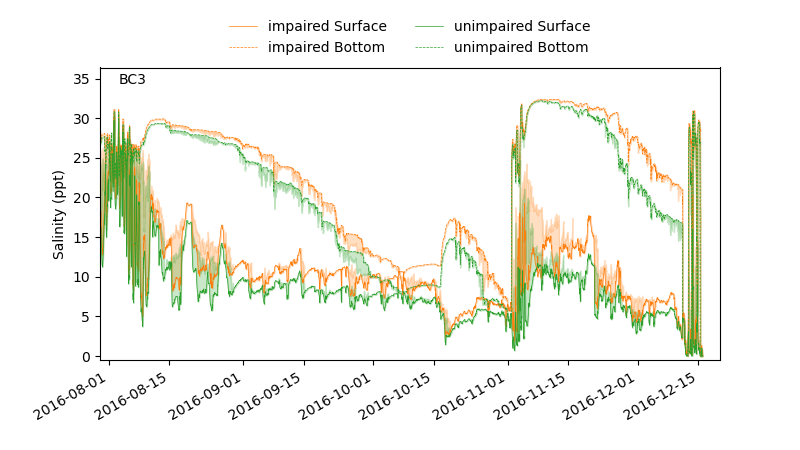

30 8


<IPython.core.display.Javascript object>


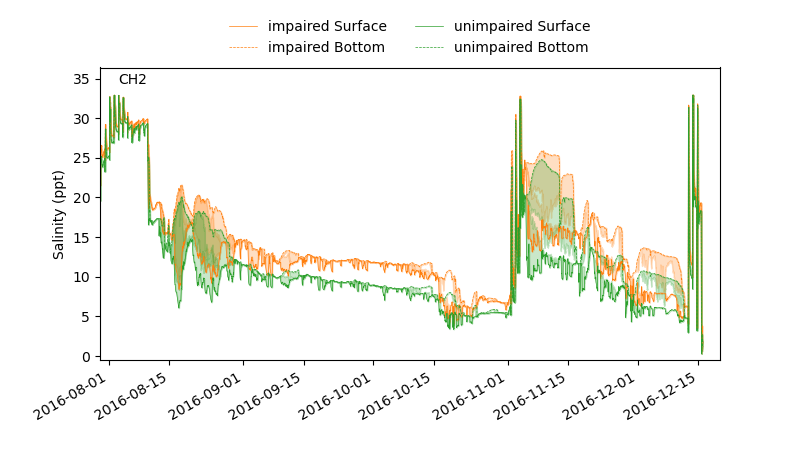

30 8


In [68]:
run_dirs=[m.run_dir for m in models[2:]]
kws=dict(zoom=(17012.0, 17155, -0.5, 36.4),show_observed=False,
         fig_name='salt_ts_asbuilt_{name}.png')
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)

<IPython.core.display.Javascript object>


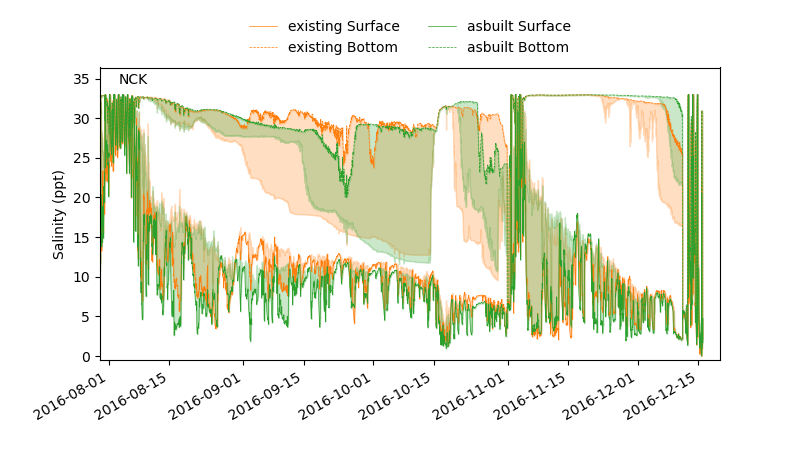

22 9


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


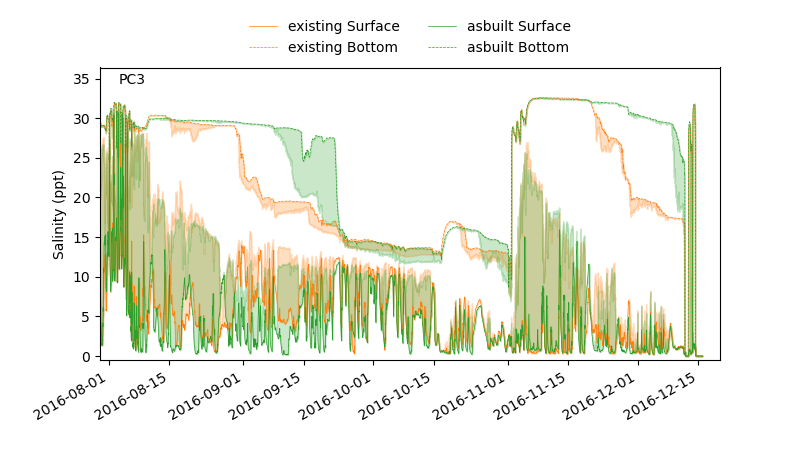

22 9


<IPython.core.display.Javascript object>


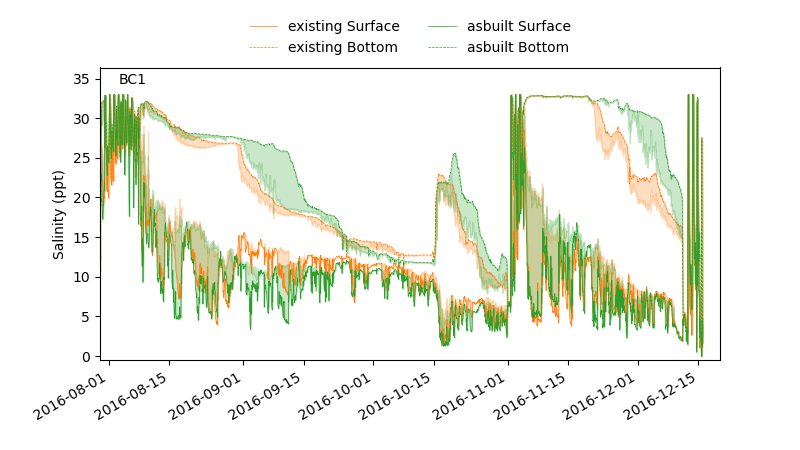

22 9


<IPython.core.display.Javascript object>


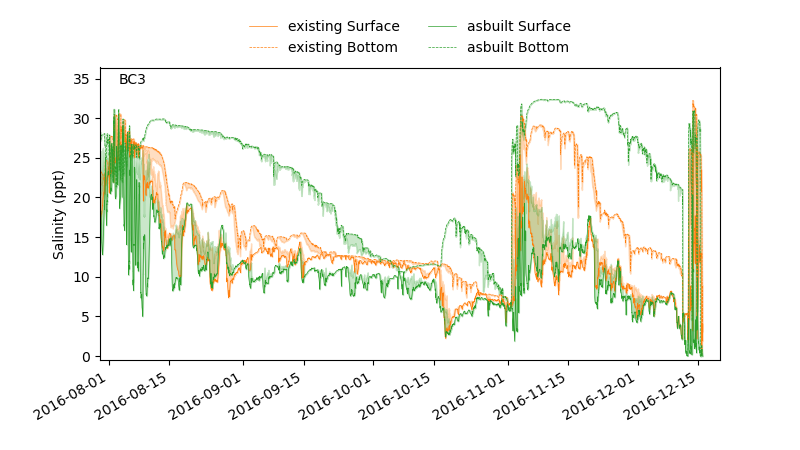

22 9


<IPython.core.display.Javascript object>


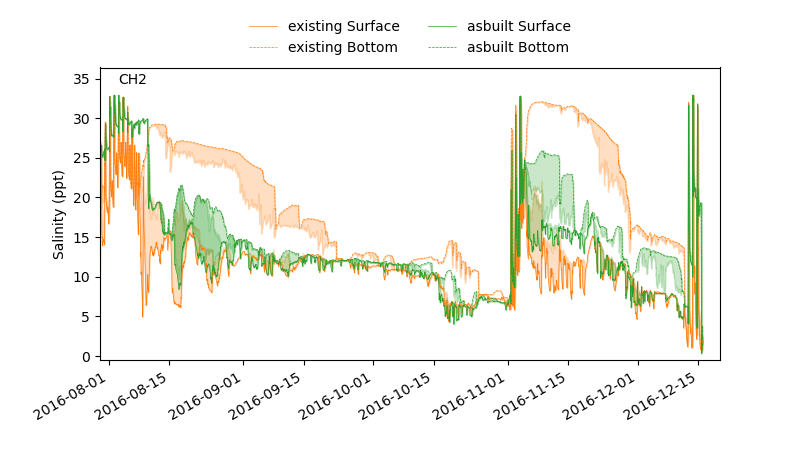

22 9


In [69]:
run_dirs=[models[0].run_dir,
          models[2].run_dir]
kws=dict(zoom=(17012.0, 17155, -0.5, 36.4),show_observed=False,
         fig_name='salt_ts_impaired_{name}.png')
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)

<IPython.core.display.Javascript object>


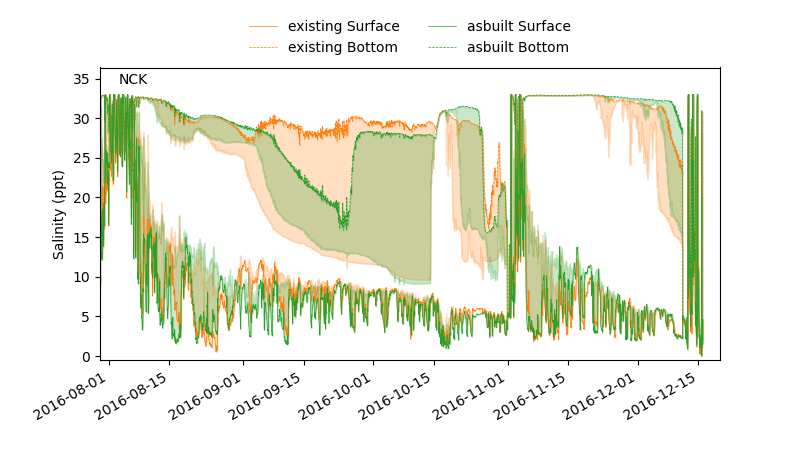

22 11


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


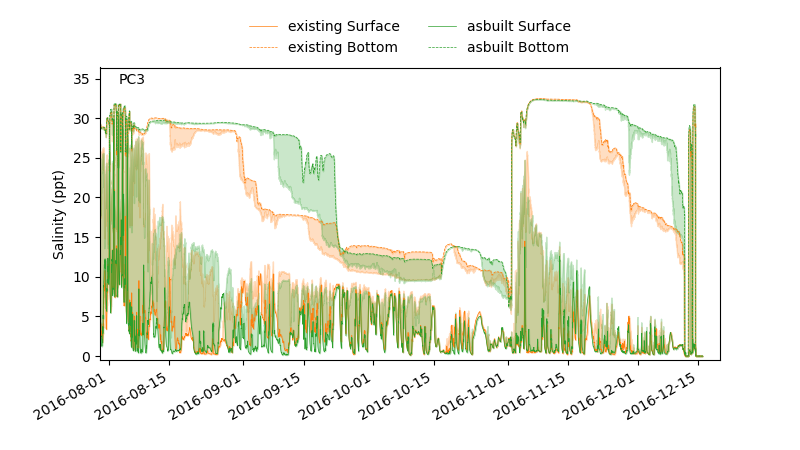

22 11


<IPython.core.display.Javascript object>


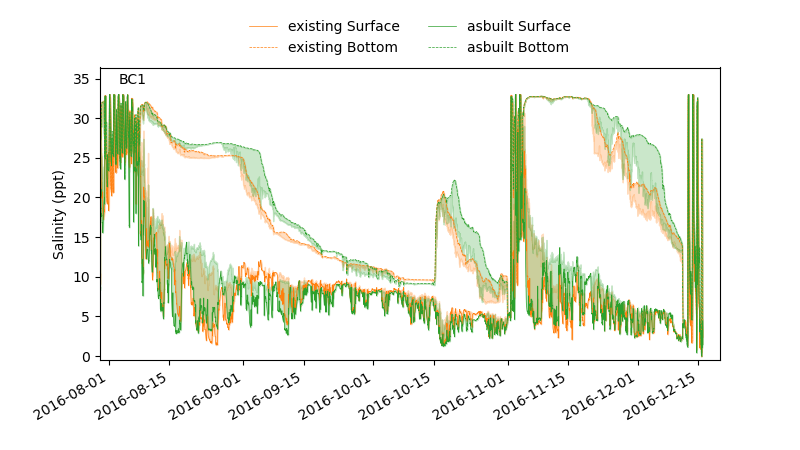

22 11


<IPython.core.display.Javascript object>


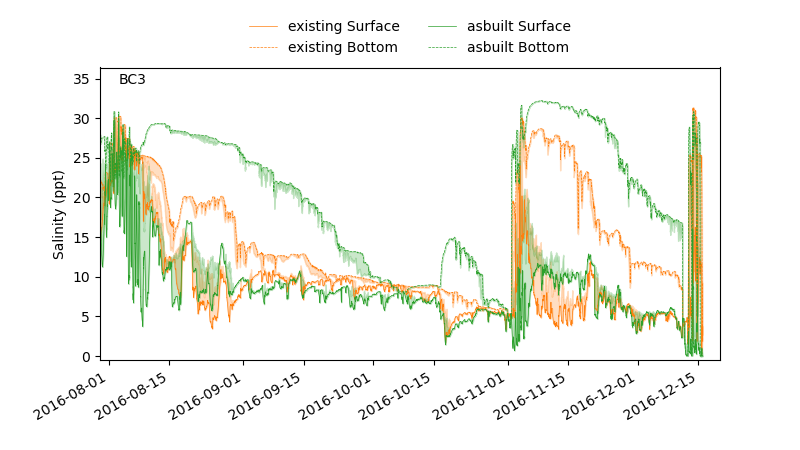

22 11


<IPython.core.display.Javascript object>


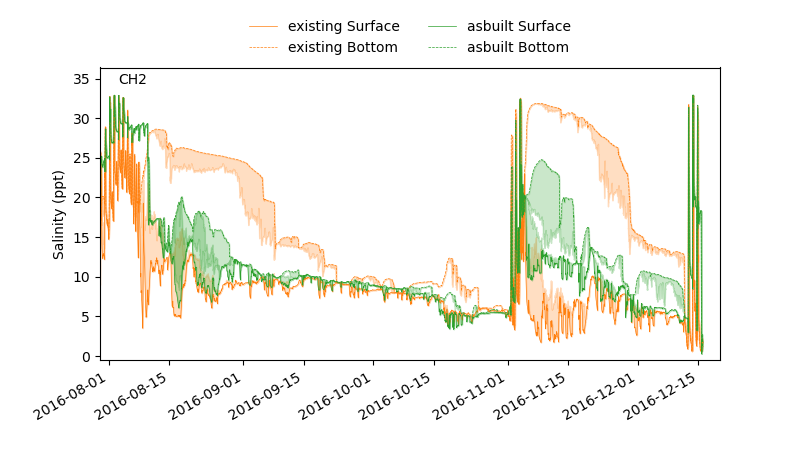

22 11


In [70]:
run_dirs=[models[1].run_dir,
          models[3].run_dir]
kws=dict(zoom=(17012.0, 17155, -0.5, 36.4),show_observed=False,
         fig_name='salt_ts_unimpaired_{name}.png')
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)

Other figures for Impaired/Unimpaired Flows
--

Time when each cell's depth average salinity decreases to some threshold.
Some measure of stratification:
 * 

In [11]:
six.moves.reload_module(multi_ugrid)
mu=multi_ugrid.MultiUgrid(f"{models[0].run_dir}/DFM_OUTPUT_flowfm/*_map.nc",
                         cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo